# Titanic: Machine Learning from Disaster


## 1. Business Understanding 
Our analysis will be based on the Titanic data set provided by Kaggle. The objective is to predict whether a passenger will survive the disaster that happened to the ship.

## 2. Data Understanding

### Import Libraries
First, we need to import several Python libraries and functionalities that we are going to use in the analysis. As for the algorithms, we shall use those that we have learned within the class first before implementing other complex ones.

In [1248]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# handle data structure
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100

# modelling algorithms and helpers
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
# from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

# data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

### Loading Data
We will now load our training data and have a quick look on it.

In [1249]:
# get the training and test data as a Dataframe
train = pd.read_csv("../Titanic/train.csv")
test = pd.read_csv("../Titanic/test.csv")

# combining training and testing data for feature engineering
full = train.append(test, ignore_index = True)


print("Datasets:", "full:", full.shape, "train:", train.shape, "test:", test.shape)

Datasets: full: (1309, 12) train: (891, 12) test: (418, 11)


The test set doesn't have the survival column, hence the 11 variables.
### Statistical Summaries
Let's have a look at some statistical summaries to see if there's any relationship between the passenger attributes with the response variable, Survived.

In [1250]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We know that there are 12 variables, but the some of the variable names are not too intuitive. Let's list down to make it clearer:

**Variable Descriptions:**
* PassengerId: Passenger's ID
* Survived: Survived (1)
* Pclass: Passenger's class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Name: Passenger's name
* Sex: Passenger's sex
* Age: Passenger's age
* SibSp: Number of siblings/spouses aboard
* Parch: Number of parents/children aboard
* Ticket: Ticket number
* Fare: Passenger's fare
* Cabin: Passenger's cabin
* Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

More information can be found on the [Kaggle](https://www.kaggle.com/c/titanic/data) website. Now let's take a look on some basic  statistics on the numberical variables.

In [1251]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There seems to be some missing data in Age which we will clean up later. There is also a minimum age of 0.42 which seems weird. However, looking back at the variable notes on the [Kaggle](https://www.kaggle.com/c/titanic/data) website, it seems that Age is fractional if less than 1. So this 0.42 might belong to a baby. Everything else looks good.

### Data Visualisations
Let's plot some visualisations to further understand the data, starting with a correlation heat map to see which variables are important.

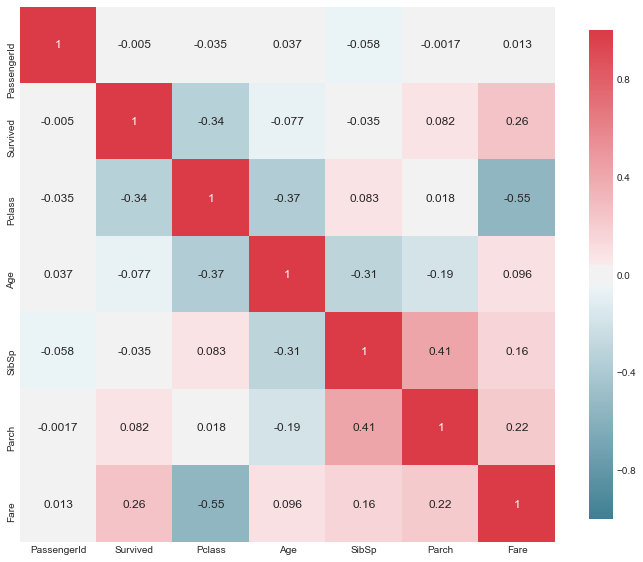

In [1252]:
# correlation between variables in train
corr = train.corr()
# creating the correlation heat map
def plot_correlation_map(df):
    _, ax = plt.subplots(figsize = (12, 10))
    cmap = sns.diverging_palette(220,10, as_cmap = True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap, 
        vmin = -1,
        vmax = 1,
        square = True, 
        cbar_kws = {'shrink': .9}, 
        ax = ax, 
        annot = True, 
        annot_kws = {'fontsize': 12})
# plotting the correlation heat map
plot_correlation_map(train)

None of the correlations are strong with the exception of Pclass-Fare which is negatively correlated. This makes sense as the higher classes (1st) will have a more expensive fare.  There's also a moderate positive correlation between Parch and SibSp. This also makes sense as people with spouses are more inclined to have children. 

Let's explore further at the relationship between the attributes and the survival of passengers. We start with the age of passengers.

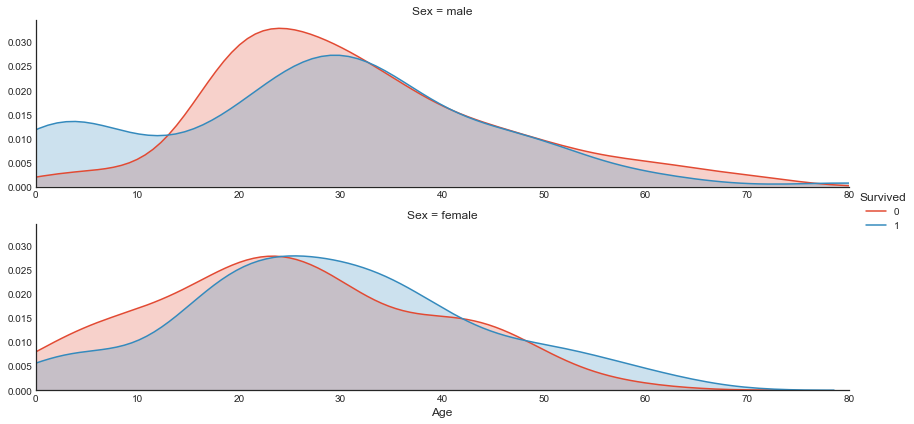

In [1253]:
# creating the distributions
def plot_distributions(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()

# plotting kernel density estimate for age
plot_distributions(train, var = 'Age', target = 'Survived', row = 'Sex')

The differences between the two lines is somehwat clear, which means that Age can be probably be a good variable for our predictive model. In other words, if the line are the same and there was no difference, it would be hard to use age as a predictive variable in our model as it indicates nothing. 

Here, we can see that in males, those aged lower than 12 have a higher chance to survive while those who are older have a higher probability to not survive. 

Comparing this with the females, those who are lower than 22 have a lower chance to survive compared to those who are above.

Let's try this again for the fare of passengers.

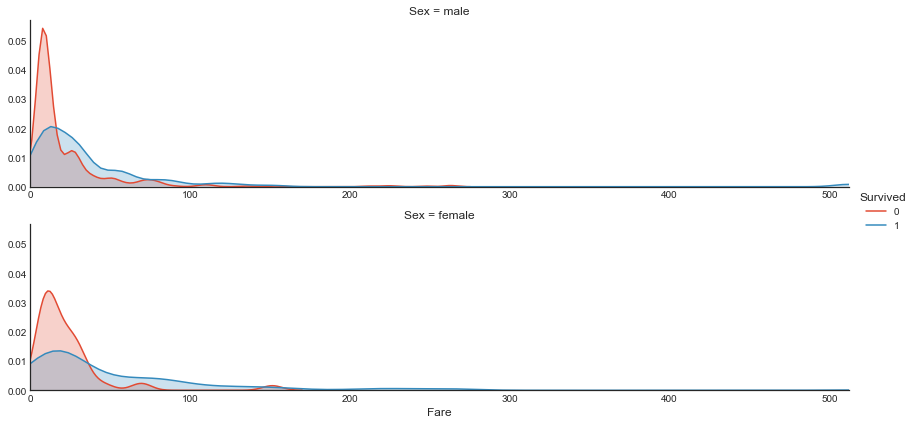

In [1254]:
# plotting kernel density estimate for fare
plot_distributions(train, var = 'Fare', target = 'Survived', row = 'Sex')

The lower the fare, the lower the chance to survive, especially in males. This might be due to the class rather than the fare. Remember that those two are strongly negatively correlated. We can check the distributions for class by plotting a bar plot as it is a categorical variable.

Let's look at some of the categorical data and their relationship with survival, starting with Pclass.

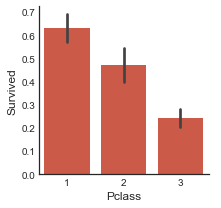

In [1255]:
# creating the bar plots
def plot_categories(df, categ, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, row = row, col = col)
    facet.map(sns.barplot, categ, target)
    facet.add_legend()

# plotting survival rate by Pclass
plot_categories(train, categ = 'Pclass', target = 'Survived')

As expected, we see the opposite of the graphs for passenger's fare where the 1st class passengers had a higher survival rate. Next, we look at the ports from which the passengers embarked.

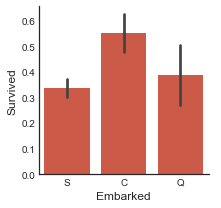

In [1256]:
# plotting survival rate by Embarked
plot_categories(train, categ = 'Embarked', target = 'Survived')

The passengers from Cherboug seems to have the highest chance of survival, followed by Queenstown and lastly, Southampton. The route of the Titanic was from Southampton to Cherboug and then to Queenstown. Since Southampton was the port where the ship sailed, there are probably more people who embarked from there which caused the survival rate to be lower as the distribution of classes are probably not the same across ports. Let's confirm this with a simple bar chart.

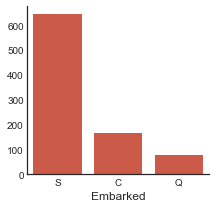

In [1257]:
# creating bar chart
def plot_counts(df, catego, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, row = row, col = col)
    facet.map(sns.countplot, catego)
    facet.add_legend()

# plotting counts of Embarked
plot_counts(train, catego = 'Embarked')

It seems Southampton had the highest amount of passenger by far, but Cherboug was not the lowest. Yet, Queenstown had a higher survival rate, albeit by a small margin.

Let's look at other categorical variables and their survival rates.

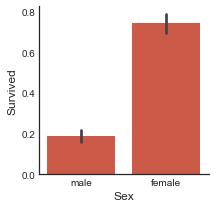

In [1258]:
# plotting survival rate by Sex
plot_categories(train, categ = 'Sex', target = 'Survived')

Massive survival rate for a female compared to a male.

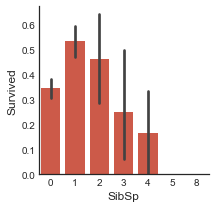

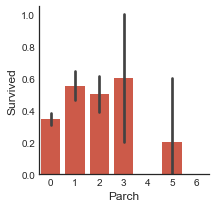

In [1259]:
# plotting survival rate by SibSp
plot_categories(train, categ = 'SibSp', target = 'Survived')

# plotting survival rate by Parch
plot_categories(train, categ = 'Parch', target = 'Survived')

## 3. Data Preprocessing

In this part, we will apply feature engineering to either transform categorical variables such as Embarked, Pclass and Sex to numeric variables or create new variables from existing ones. Transforming the data will ensure compability with some of the algorithms. 

New dummy variables will be created for every unique value of the categorical variables. The variables will have a value of 1 if the row has a particular value and a value of 0 if not. Sex will be coded as a binary variable since it is dichotomous.

We also noticed previously that Age has several values missing. Let's check what other variables have missing data and appropriately deal with them in this part.

In [1260]:
full.apply(lambda x: sum(x.isnull()), axis = 0)

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Apart from Age, there seems to be alot of Cabin values missing, 2 from Embarked and 1 from Fare. Let's process the variables one by one.

### Processing Age

In [1261]:
# fill missing values of Age with the mean of Age
full.Age.fillna(full.Age.mean(), inplace = True)

### Processing Name

In [1262]:
# extract title from name
full['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

# the 'family' in which the titles belong
Title_Dict = {
              "Capt":        "Officer",
              "Col":         "Officer",
              "Major":       "Officer",
              "Jonkheer":    "Royalty",
              "Don":         "Royalty",
              "Sir":         "Royalty",
              "Dr":          "Officer",
              "Rev":         "Officer",
              "the Countess":"Royalty",
              "Dona":        "Royalty",
              "Mme":         "Mrs",
              "Mlle":        "Miss",
              "Ms":          "Mrs",
              "Mr":          "Mr",
              "Mrs":         "Mrs",
              "Miss":        "Miss",
              "Master":      "Master",
              "Lady":        "Royalty"
              }

# map each title to family
full['Title'] = full.Title.map(Title_Dict)

# dummy variables
title = pd.get_dummies(full['Title'], prefix = 'Title')

# adding dummy variables to dataframe
full = pd.concat([full, title], axis = 1)

# removing the Name variable
full.drop('Name', axis = 1, inplace = True)

# removing the Title variable
full.drop('Title', axis = 1, inplace = True)

We extract the passenger's title from the name. We then create a dummy variable from the titles. After that, we dropped the Name and Title variables since we no longer need them.

### Processing Fare

In [1263]:
# fill missing values of Fare with the mean of Fare
full.Fare.fillna(full.Fare.mean(), inplace = True)

### Processing Embarked

In [1264]:
# fill missing values of Embarked with Southampton (most frequent)
full.Embarked.fillna('S', inplace = True)

# dummy variables for Embarked
embarked = pd.get_dummies(full.Embarked, prefix = 'Embarked')

# adding dummy variables to dataframe
full = pd.concat([full, embarked], axis = 1)

# removing the Embarked variable
full.drop('Embarked', axis = 1, inplace = True)

### Processing Cabin

In [1265]:
# fill missing values of Cabin with Unknown (U) 
full.Cabin.fillna('U', inplace = True)

# mapping each Cabin value with the first letter
full['Cabin'] = full['Cabin'].map(lambda x: x[0])

# dummy variables for Cabin
cabin = pd.get_dummies(full['Cabin'], prefix = 'Cabin')

# adding dummy variables to dataframe
full = pd.concat([full, cabin], axis = 1)

# removing the Cabin variable
full.drop('Cabin', axis = 1, inplace = True)


### Processing Sex

In [1266]:
# transform Sex into a binary
full['Sex'] = full['Sex'].map({'male':1, 'female':0})

### Processing Pclass

In [1267]:
# dummy variables for Pclass
pclass = pd.get_dummies(full.Pclass, prefix = 'Pclass')

# adding dummy variables to dataframe
full = pd.concat([full, pclass], axis = 1)

# removing the Cabin variable
full.drop('Pclass', axis = 1, inplace = True)

### Processing Ticket
We create a function that extracts the prefix of a ticket, and if it fails, it returns XXX.

In [1268]:
# extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'
    

# dummy variables from tickets:
full['Ticket'] = full['Ticket'].map(cleanTicket)
tickets = pd.get_dummies(full['Ticket'], prefix='Ticket')

# adding dummy variables to dataframe
full = pd.concat([full, tickets], axis = 1)

# removing the Ticket variable
full.drop('Ticket', inplace = True, axis = 1)

### Processing Family
Here, we create a new variable based on the size of the family. This is done under the assumption that large families are grouped together, hence they are more likely to get rescued than people travelling alone.

In [1269]:
# creating a new variable, the size of the family including passenger
full['FamSize'] = full['Parch'] + full['SibSp'] + 1

# creating a new variable based on the size of the family
full['Single'] = full['FamSize'].map(lambda x: 1 if x == 1 else 0)
full['SmallFam'] = full['FamSize'].map(lambda x: 1 if 2 <= x <= 4 else 0)
full['BigFam'] = full['FamSize'].map(lambda x: 1 if 5 <= x else 0)

* FamSize: the total number within the family including passenger
* Single: family size of 1
* SmallFam: family size between 2 and 4
* BigFam: family size of more than 5

In [1270]:
full.shape

(1309, 69)

We now have 68 features (1 variable is Survived). Let's see the first five data.

In [1271]:
full.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamSize,Single,SmallFam,BigFam
0,22.0,7.2500,0,1,1,1,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
1,38.0,71.2833,0,2,0,1,1.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,26.0,7.9250,0,3,0,0,1.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,35.0,53.1000,0,4,0,1,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0
4,35.0,8.0500,0,5,1,0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


In [1272]:
# removing the PassengerId since we no longer need it
full.drop('PassengerId', inplace = True, axis = 1)

# removing the Survived since we are going to learn from the training data
full.drop('Survived', inplace = True, axis = 1)

full.head()

,Age,Fare,Parch,Sex,SibSp,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamSize,Single,SmallFam,BigFam
0,22.0,7.2500,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
1,38.0,71.2833,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,26.0,7.9250,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,35.0,53.1000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0
4,35.0,8.0500,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


## 4. Modelling

Now we are going to use a few models to test which one is the best at predicting whether a passenger survives or not.

First, we break our combined dataset into a train set and a test set. We then use the train set to build a predictive model and evaluate the model using the set. Lastly, we test the model using the test set and generate the output file for submission.


For our model evaluation, we will be using a 5-fold cross validation with the Accuracy metric. The cross validation will reduce the problem of overfitting.

In [1273]:
# evaluation score
def model_score(clf, X, y, scoring = 'accuracy'):
    xval = cross_val_score(clf, X, y, cv =5, scoring = scoring)
    return np.mean(xval)

# our response variable, train and test set
targets = pd.read_csv("../Titanic/train.csv").Survived
train = full.head(891)
test = full.iloc[891:]

### Feature Selection
We have 67 features and we would like to decrease the dimensionality by selecting the 'right' number of features that capture the essential information.

Tree-based estimators can be used to compute feature importances which we can use to discard those that are irrelevant.

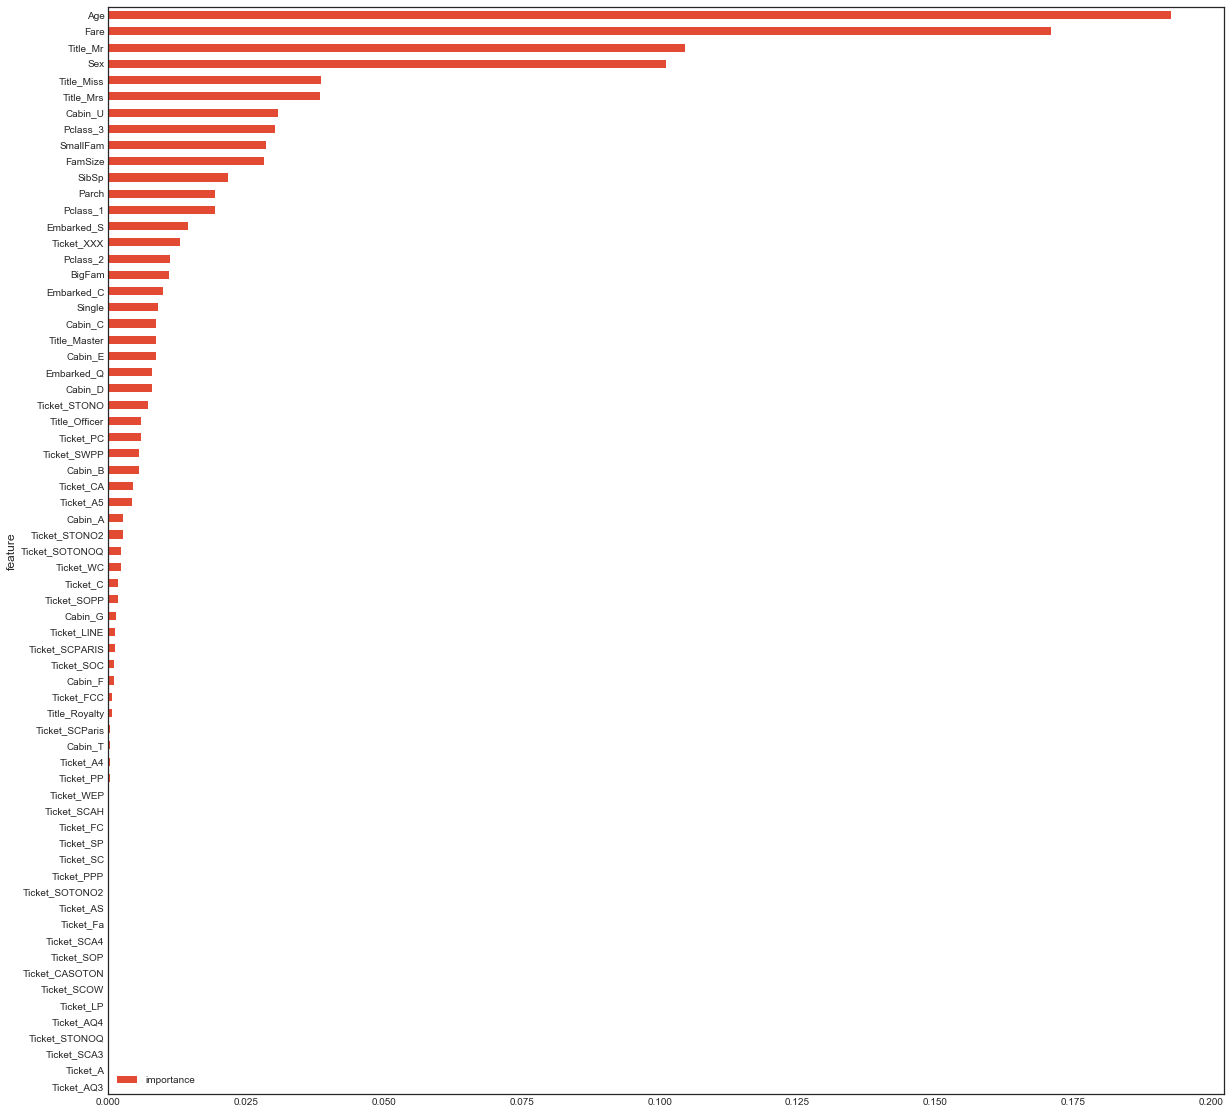

In [1274]:
clf = RandomForestClassifier(n_estimators = 50, max_features = 'sqrt')
clf = clf.fit(train, targets)

features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)

# plot feature importances
features.plot(kind = 'barh', figsize = (20, 20))

There seems to be a great importance linked to Age, Fare, Sex and Title_Mr. Now, let's reduce our dimensionality and have a more compact data set.

In [1275]:
model = SelectFromModel(clf, prefit = True)
train_reduced = model.transform(train)
train_reduced.shape

(891, 13)

In [1276]:
test_reduced = model.transform(test)
test_reduced.shape

(418, 13)

We are now reduced to only 12 features. 

We now proceed with our first model, Random Forest. However, before that, we need to tweak its parameters first in order to ge the optimal model for prediction.

In [1277]:
# turn run_gs to True if you want to use gridsearch again
run_gs = False

if run_gs:
    parameter_grid = {
                    'max_depth': [4, 6, 8],
                    'n_estimators': [50, 10],
                    'max_features': ['sqrt', 'auto', 'log2'],
                    'min_samples_split': [2, 3, 10],
                    'min_samples_leaf': [1, 3, 10],
                    'bootstrap': [True, False],
                    }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(targets, n_folds = 5)
    
    grid_search = GridSearchCV(forest, 
                               scoring = 'accuracy', 
                               param_grid = parameter_grid,
                               cv = cross_validation)
    
    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_
    
    print('Best Score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else:
    parameters = {'bootstrap': False,
                 'min_samples_leaf': 3,
                 'n_estimators': 50,
                 'min_samples_split': 10,
                 'max_features': 'sqrt',
                 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

In [1278]:
model_score(model, train, targets, scoring = 'accuracy')

0.82721560174580566

A good score for Random Forest. Let's use the model with our test data and submit.

In [1279]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../Titanic/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId', 'Survived']].to_csv('../Titanic/output.csv', index = False)

**References**
1. [An Interactive Data Science Tutorial](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial) - Helge Bjorland
2. [How to score 0.8134 in Titanic Kaggle Challenge](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html) - Ahmed Besbes